## Classifying Shark Species Image Data and Conservation Status

In [85]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import numpy as np
import os
import pandas as pd
import shutil # For moving files
from roboflow import Roboflow

In [86]:
# Authenticate and download the dataset
rf = Roboflow(api_key="c9vR8Ap1lGCVx06U1KI2")
project = rf.workspace("project3-zhzbg").project("shark-species-dataset-818gy")
version = project.version(1)
dataset = version.download("tensorflow") # Downloads the data to a local path

# Define data paths
dataset_path = "/content/Shark-Species-Dataset-1"
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")

loading Roboflow workspace...
loading Roboflow project...


## IUCN Conservation Data Integration

In [87]:

conservation_status_map = {
    "Lemon_Shark": "Near Threatened (NT)",
    "Hammerhead_Shark": "Endangered (EN)",
    "Mako_Shark": "Endangered (EN)",
    "Whale_Shark": "Endangered (EN)",
    "Sand_Tiger_Shark": "Vulnerable (VU)",
    "Tiger_Shark": "Near Threatened (NT)",
    "Blue_Shark": "Near Threatened (NT)",
    "Nurse_Shark": "Vulnerable (VU)",
    "Thresher_Shark": "Vulnerable (VU)",
    "Whitetip_Shark": "Near Threatened (NT)",
    "Great-White_Shark": "Vulnerable (VU)",
    "Dusky_Shark": "Endangered (EN)",
    "Blacktip_Shark": "Vulnerable (VU)" # Added Blacktip Shark
}

## Data Reorganization

In [88]:

# define a placeholder for all class labels
global_class_labels = []

def reorganize_data(data_path, known_classes=None):
    annotations_file = os.path.join(data_path, "_annotations.csv")
    if not os.path.exists(annotations_file):
        print(f"Annotations file not found in {data_path}. Skipping reorganization.")
        return

    df = pd.read_csv(annotations_file)

    class_col = None
    if 'class' in df.columns:
        class_col = 'class'
    elif 'label' in df.columns:
        class_col = 'label'

    if class_col is None:
        print(f"Could not find 'class' or 'label' column in {annotations_file}. Cannot reorganize.")
        return

    # Use known_classes if provided, otherwise infer from current split's annotations
    classes_to_create_dirs_for = known_classes if known_classes is not None else df[class_col].unique()

    print(f"Reorganizing data in: {data_path}")
    for class_name in classes_to_create_dirs_for: # Create directories for all known classes
        class_dir = os.path.join(data_path, class_name.replace(" ", "_")) # Replace spaces for valid directory names
        os.makedirs(class_dir, exist_ok=True)

    # Create a list of files that have been moved to prevent double-moving in case of multiple annotations per image
    moved_files = set()

    for index, row in df.iterrows():
        image_filename = row['filename']
        original_image_path = os.path.join(data_path, image_filename)

        if os.path.exists(original_image_path) and original_image_path not in moved_files:
            class_name = row[class_col].replace(" ", "_")
            destination_path = os.path.join(data_path, class_name, image_filename)
            shutil.move(original_image_path, destination_path)
            moved_files.add(original_image_path)

# Reorganize training data first to determine the full set of class labels
reorganize_data(train_dir)

Reorganizing data in: /content/Shark-Species-Dataset-1/train


## Image Data Preprocessing and Augmentation

In [89]:

# Define hyper-parameters
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
INPUT_SHAPE = IMAGE_SIZE + (3,) # 3 for color channels (RGB)

# Training Data Generator (with augmentation and rescaling)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use flow_from_directory to load images and automatically infer class labels
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Get class labels from the training generator to ensure consistency across all splits
NUM_CLASSES = train_generator.num_classes
global_class_labels = list(train_generator.class_indices.keys())
print(f"Discovered {NUM_CLASSES} classes from training data: {global_class_labels}")

# Now reorganize validation and test data using the global_class_labels
# This ensures all class directories exist for consistency, even if empty.
reorganize_data(valid_dir, known_classes=global_class_labels)
reorganize_data(test_dir, known_classes=global_class_labels)

# Validation and Test Data Generators (only rescaling)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=global_class_labels # Ensure consistency across splits
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, # Important for evaluation/prediction later
    classes=global_class_labels # Ensure consistency across splits
)

# Verify that all generators now have the correct number of classes
print(f"Train Generator num_classes: {train_generator.num_classes}")
print(f"Validation Generator num_classes: {validation_generator.num_classes}")
print(f"Test Generator num_classes: {test_generator.num_classes}")

Found 1228 images belonging to 16 classes.
Discovered 16 classes from training data: ['Basking_Shark', 'Blacktip_Shark', 'Blue_Shark', 'Bull_Shark', 'Great-White_Shark', 'Hammerhead_Shark', 'Human', 'Lemon_Shark', 'Mako_Shark', 'Nurse_Shark', 'Ramona', 'Sand_Tiger_Shark', 'Thresher_Shark', 'Tiger_Shark', 'Whale_Shark', 'Whitetip_Shark']
Reorganizing data in: /content/Shark-Species-Dataset-1/valid
Reorganizing data in: /content/Shark-Species-Dataset-1/test
Found 155 images belonging to 16 classes.
Found 155 images belonging to 16 classes.
Train Generator num_classes: 16
Validation Generator num_classes: 16
Test Generator num_classes: 16


## Convolutional Neural Network (CNN)
A deep architecture designed for >80% accuracy



In [90]:

model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 4 (Deeper)
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Classification Head
    Flatten(),
    Dropout(0.5), # Regularization to prevent overfitting

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax') # Output layer for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │         8,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,823,632 (26.03 MB)

 Trainable params: 6,821,648 (26.02 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Model Trainning

## Load Pre-trained Base Model
Import MobileNetV2 and load it as a pre-trained base model without the top classification layer, using ImageNet weights and the previously defined input shape.



In [91]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

# Load the pre-trained MobileNetV2 model without the top classification layer
# and use ImageNet weights
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                          include_top=False,
                          weights='imagenet')

print("MobileNetV2 base model loaded successfully.")

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


MobileNetV2 base model loaded successfully.


In [92]:
base_model.trainable = False
print("Base model layers frozen successfully.")

Base model layers frozen successfully.


## Add Custom Classification Head
To construct the new classification head, I will import `GlobalAveragePooling2D` and then build a new Sequential model by stacking `GlobalAveragePooling2D`, `Dense`, and `Dropout` layers on top of the frozen `base_model`, finishing with a `Dense` output layer for classification.



In [93]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Construct the new classification head on top of the frozen base model
model_transfer = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

print("New classification head constructed successfully.")

New classification head constructed successfully.


## Compile the New Model
Compile the new model, consisting of the frozen base and the custom head, with an appropriate optimizer (e.g., Adam with a lower learning rate for fine-tuning) and loss function for multi-class classification.


In [94]:
from tensorflow.keras.optimizers import Adam

# Compile the new model
model_transfer.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully with Adam optimizer (learning_rate=0.0001) and categorical_crossentropy loss.")

Model compiled successfully with Adam optimizer (learning_rate=0.0001) and categorical_crossentropy loss.


## Train the Model

Re-train the model using the prepared image data generators. The training will focus on updating the weights of the newly added classification head. Early stopping will be used to prevent overfitting.


In [95]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_transfer = model_transfer.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)

print("Model training for transfer learning completed.")

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 643ms/step - accuracy: 0.0597 - loss: 3.4765 - val_accuracy: 0.1032 - val_loss: 2.6718
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 599ms/step - accuracy: 0.1243 - loss: 2.8398 - val_accuracy: 0.2452 - val_loss: 2.4675
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 615ms/step - accuracy: 0.1579 - loss: 2.5988 - val_accuracy: 0.2774 - val_loss: 2.3655
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 614ms/step - accuracy: 0.1852 - loss: 2.5457 - val_accuracy: 0.3290 - val_loss: 2.2635
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 627ms/step - accuracy: 0.2029 - loss: 2.4290 - val_accuracy: 0.3742 - val_loss: 2.1567
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 605ms/step - accuracy: 0.2599 - loss: 2.3383 - val_accuracy: 0.3935 - val_loss: 2.0351
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 605ms/step - accuracy: 0.2756 - loss: 2.2996 - val_accuracy: 0.4387 - val_loss: 1.9563
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 614ms/step - accuracy: 0.3035 - loss: 2.2016 - val_accu

## Evaluate New Model Performance


In [100]:
from sklearn.metrics import classification_report

# Generate predictions for the transfer learning model
test_generator.reset()
all_predictions_transfer = model_transfer.predict(test_generator, steps=len(test_generator))
all_predicted_indices_transfer = np.argmax(all_predictions_transfer, axis=1)

# Get true labels from the test generator
y_true_transfer = test_generator.classes

# Get the unique labels present in y_true_transfer
unique_labels_transfer = np.unique(y_true_transfer)

# Map these unique labels back to their class names for the report
filtered_target_names_transfer = [global_class_labels[i] for i in unique_labels_transfer]

# Generate classification report
report_transfer = classification_report(y_true_transfer, all_predicted_indices_transfer, labels=unique_labels_transfer, target_names=filtered_target_names_transfer, zero_division=0)
print(
"\n--- Classification Report (Transfer Learning Model) ---")
print(report_transfer)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step

--- Classification Report (Transfer Learning Model) ---
                   precision    recall  f1-score   support

    Basking_Shark       0.71      1.00      0.83         5
   Blacktip_Shark       0.45      0.42      0.43        12
       Blue_Shark       0.78      0.54      0.64        13
       Bull_Shark       0.22      0.17      0.19        12
Great-White_Shark       0.73      0.73      0.73        15
 Hammerhead_Shark       0.29      0.20      0.24        10
      Lemon_Shark       0.53      0.62      0.57        13
       Mako_Shark       0.38      0.43      0.40        14
      Nurse_Shark       0.00      0.00      0.00         4
 Sand_Tiger_Shark       0.83      0.71      0.77         7
   Thresher_Shark       0.56      0.64      0.60        14
      Tiger_Shark       0.36      0.67      0.47         6
      Whale_Shark       0.80      0.80      0.80        15
   Whitetip_Shark       0.62      0.67      0.65        15

         accuracy

## Visualize New Training History


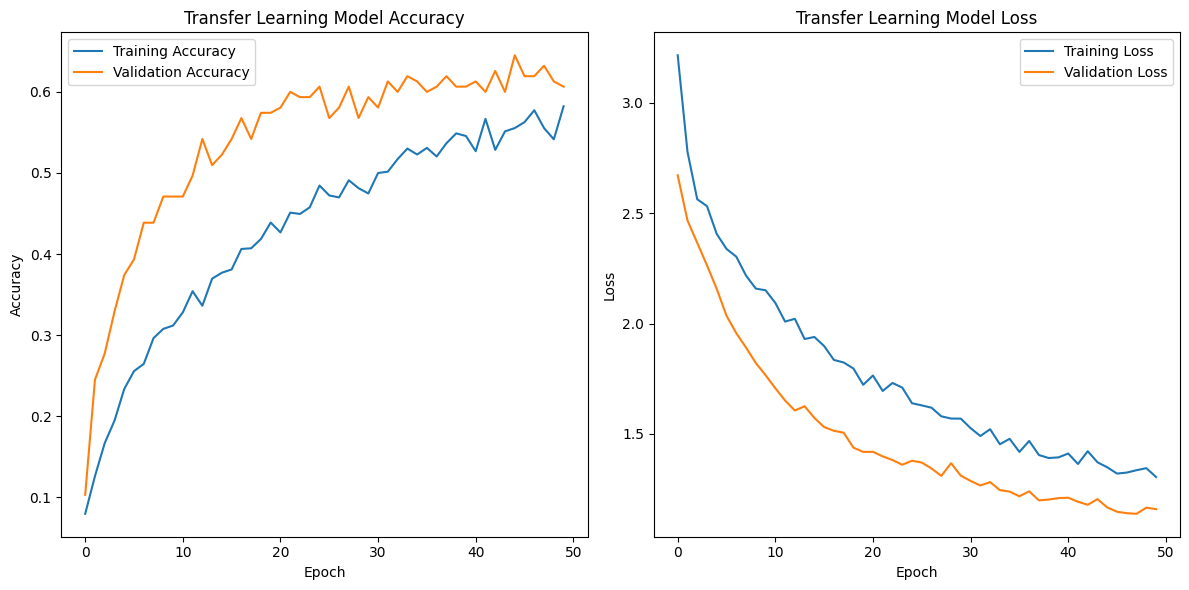

Plots generated for transfer learning training and validation accuracy and loss.


In [101]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(history_transfer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot 2: Loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(history_transfer.history['loss'], label='Training Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

print("Plots generated for transfer learning training and validation accuracy and loss.")

In [109]:
# Re-evaluating the model to ensure accuracy_transfer holds the correct value
loss_transfer, accuracy_transfer = model_transfer.evaluate(test_generator, steps=len(test_generator), verbose=0)

print(f"Overall Accuracy of the Transfer Model: {accuracy_transfer:.2%}")
print(f"Overall Loss of the Transfer Model: {loss_transfer:.4f}")

Overall Accuracy of the Transfer Model: 55.48%
Overall Loss of the Transfer Model: 1.3639



--- Classified Test Set Conservation Summary (Transfer Learning Model - Excluding Unknown Status) ---
IUCN Status
Near Threatened (NT)    51
Vulnerable (VU)         50
Endangered (EN)         38
Name: count, dtype: int64


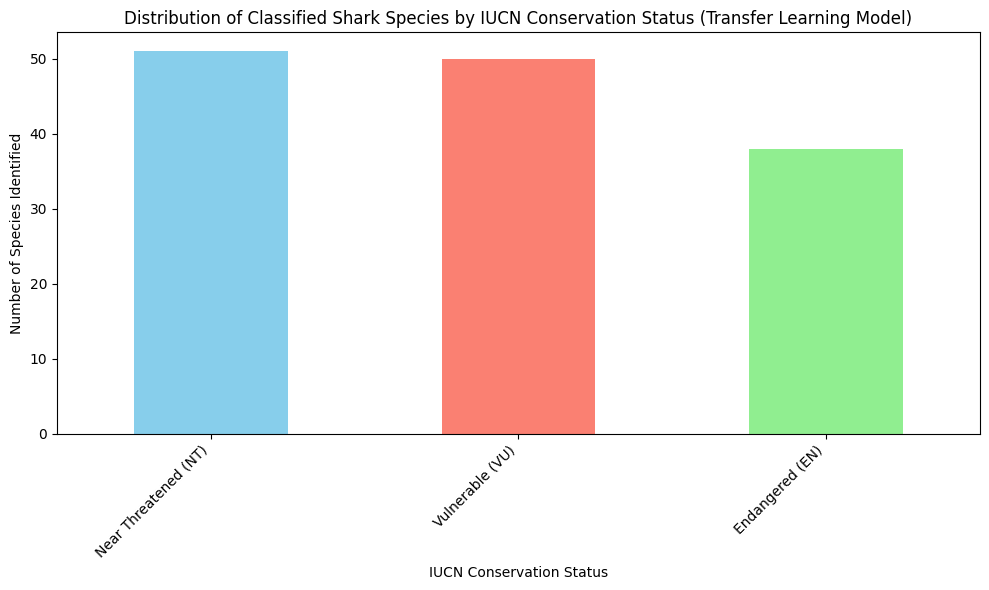

Bar chart for IUCN conservation status distribution from transfer learning model generated.


In [102]:
# Map predicted indices from the transfer learning model back to class names
all_predicted_classes_transfer = [global_class_labels[i] for i in all_predicted_indices_transfer]

# Create a new report DataFrame using predictions from the transfer learning model
report_data_transfer = {
    'Predicted Species': all_predicted_classes_transfer,
    'IUCN Status': [conservation_status_map.get(s, "Status Unknown / Not in IUCN Map") for s in all_predicted_classes_transfer]
}
report_df_transfer = pd.DataFrame(report_data_transfer)

# Filter out species with "Status Unknown / Not in IUCN Map" before summarizing
filtered_report_df_transfer = report_df_transfer[report_df_transfer['IUCN Status'] != "Status Unknown / Not in IUCN Map"]

# Show a summary of conservation status for the classified test set using the transfer learning model
conservation_summary_transfer = filtered_report_df_transfer['IUCN Status'].value_counts()
print("\n--- Classified Test Set Conservation Summary (Transfer Learning Model - Excluding Unknown Status) ---")
print(conservation_summary_transfer)

import matplotlib.pyplot as plt

# Create a bar chart for conservation status summary from the transfer learning model
plt.figure(figsize=(10, 6))
conservation_summary_transfer.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange', 'purple'])
plt.title('Distribution of Classified Shark Species by IUCN Conservation Status (Transfer Learning Model)')
plt.xlabel('IUCN Conservation Status')
plt.ylabel('Number of Species Identified')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout()
plt.show()

print("Bar chart for IUCN conservation status distribution from transfer learning model generated.")